In [1]:
import pandas as pd
from scipy.stats import entropy
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv("Data/heart_disease_health_indicators_BRFSS2015.csv")

In [3]:
data['Diabetes'] = data['Diabetes'].replace(2.0, 1.0)
combination_labels = {
    (1, 1, 1): "All diseases",
    (1, 0, 0): "HD only",
    (1, 1, 0): "HD & Stroke",
    (0, 1, 1): "Stroke & Diabetic",
    (0, 0, 1): "Diabetic",
    (0, 1, 0): "Stroke",
    (1, 0, 1): "HD & Diabetic",
    (0, 0, 0): "Healthy"
}

def label_combinations(row):
    return combination_labels[(row['HeartDiseaseorAttack'], row['Stroke'], row['Diabetes'])]

# Apply the function to create a new column
data['DiseaseCombination'] = data.apply(label_combinations, axis=1)

combination_labels = {
    (1, 1): "HD & Stroke",
    (1, 0): "HD",
    (0, 1): "Stroke",
    (0, 0): "Healthy"
}

# Function to map combinations of HD and Stroke to labels
def label_combinations(row):
    return combination_labels[(row['HeartDiseaseorAttack'], row['Stroke'])]

# Apply the function to create a new column
data['HDStrokeCombination'] = data.apply(label_combinations, axis=1)

def categorize_bmi(bmi):
    if bmi < 18.5:
        return 'Underweight'
    elif 18.5 <= bmi < 25:
        return 'Normal weight'
    elif 25 <= bmi < 30:
        return 'Overweight'
    else:
        return 'Obesity'

# Apply the categorization function to the BMI column
data['BMI'] = data['BMI'].apply(categorize_bmi)

In [4]:
cat_columns = ["HeartDiseaseorAttack","HighBP",'HighChol', 'CholCheck'  ,'Smoker','Stroke','Diabetes','PhysActivity','Fruits', 'Veggies',
       'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost', 'GenHlth',
       'MentHlth', 'PhysHlth', 'DiffWalk', 'Sex', 'Age', 'Education',
       'Income','BMI']

data[cat_columns]=data[cat_columns].apply(lambda x:x.astype('category'))
data.head()


,HeartDiseaseorAttack,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,Diabetes,PhysActivity,Fruits,...,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income,DiseaseCombination,HDStrokeCombination
0,0.0,1.0,1.0,1.0,Obesity,1.0,0.0,0.0,0.0,0.0,...,5.0,18.0,15.0,1.0,0.0,9.0,4.0,3.0,Healthy,Healthy
1,0.0,0.0,0.0,0.0,Overweight,1.0,0.0,0.0,1.0,0.0,...,3.0,0.0,0.0,0.0,0.0,7.0,6.0,1.0,Healthy,Healthy
2,0.0,1.0,1.0,1.0,Overweight,0.0,0.0,0.0,0.0,1.0,...,5.0,30.0,30.0,1.0,0.0,9.0,4.0,8.0,Healthy,Healthy
3,0.0,1.0,0.0,1.0,Overweight,0.0,0.0,0.0,1.0,1.0,...,2.0,0.0,0.0,0.0,0.0,11.0,3.0,6.0,Healthy,Healthy
4,0.0,1.0,1.0,1.0,Normal weight,0.0,0.0,0.0,1.0,1.0,...,2.0,3.0,0.0,0.0,0.0,11.0,5.0,4.0,Healthy,Healthy


In [5]:
def calc_mi(x,y):
    x_mod = [data[i] for i in x]
    y_mod = [data[i] for i in y]

    contingency_table = pd.crosstab(x_mod, y_mod)
    ce_table = contingency_table / np.expand_dims(contingency_table.sum(axis=1), axis=1)
    rowise_ce = np.apply_along_axis(entropy, 1, ce_table)
    marginal_prob_x = contingency_table.sum(axis=1) / contingency_table.sum().sum()
    ce = np.dot(marginal_prob_x, rowise_ce)

    marginal_prob_y = contingency_table.sum(axis=0) / contingency_table.sum().sum()
    e_y = entropy(marginal_prob_y)

    mi = e_y - ce
    return mi, ce_table

In [6]:
x_vars= ["HighBP",'HighChol', 'CholCheck'  ,'Smoker','PhysActivity','Fruits', 'Veggies',
       'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost', 'GenHlth',
       'MentHlth', 'PhysHlth', 'DiffWalk', 'Sex', 'Age', 'Education',
       'Income','BMI']

In [7]:
mi_x = []
for var in x_vars:
    mi,_ = calc_mi([var],['DiseaseCombination'])
    mi_x.append(mi)
print(mi_x)

[0.056426229663466554, 0.03556590740535859, 0.004268414910467255, 0.008431060255643441, 0.010009871615053512, 0.0010027326715013052, 0.0026013394478430207, 0.002194352469745864, 0.0002989837953824015, 0.001308279855345762, 0.07737035574791062, 0.006008438207392941, 0.02976644413282048, 0.03979444396651477, 0.003982084797427787, 0.050890215348123546, 0.013304006814860991, 0.026409436694552313, 0.024870156586959014]


In [8]:
mi_df = pd.DataFrame({'variable':x_vars,'mutual information':mi_x})
mi_df.sort_values(by='mutual information', ascending=False)

,variable,mutual information
10,GenHlth,0.077370
0,HighBP,0.056426
15,Age,0.050890
13,DiffWalk,0.039794
1,HighChol,0.035566
12,PhysHlth,0.029766
17,Income,0.026409
18,BMI,0.024870
16,Education,0.013304
4,PhysActivity,0.010010


<Axes: xlabel='Smoker'>

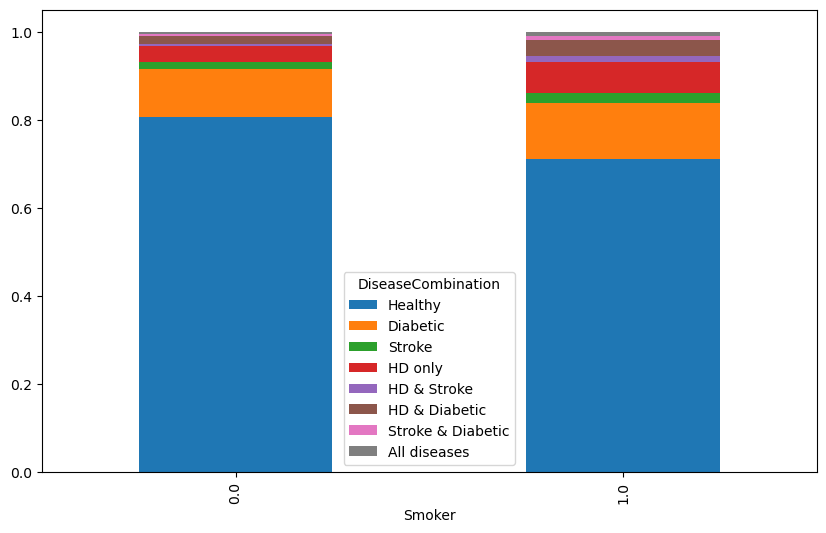

In [9]:
mi,ce_table = calc_mi(['Smoker'],['DiseaseCombination'])
column_order = ['Healthy','Diabetic','Stroke','HD only', 'HD & Stroke', 'HD & Diabetic', 'Stroke & Diabetic', 'All diseases']
ce_table = ce_table[column_order]
ce_table.plot(kind = 'bar', stacked=True, figsize=(10,6))


In [10]:
x_pairs = []
for i in range(len(x_vars)):
    for j in range(len(x_vars)):
        if i != j :
            x_pairs.append([x_vars[i],x_vars[j]])


In [11]:
mi_twoway = []
for i in x_pairs:
    mi,_ = calc_mi(i,['DiseaseCombination'])
    mi_twoway.append(mi)

In [12]:
mi_df2 = pd.DataFrame({'variable':x_pairs,'mutual information':mi_twoway})
mi_df2.sort_values(by='mutual information', ascending=False).head(30)

,variable,mutual information
280,"[Age, GenHlth]",0.121497
194,"[GenHlth, Age]",0.121497
9,"[HighBP, GenHlth]",0.108400
180,"[GenHlth, HighBP]",0.108400
27,"[HighChol, GenHlth]",0.098925
181,"[GenHlth, HighChol]",0.098925
334,"[BMI, GenHlth]",0.091703
197,"[GenHlth, BMI]",0.091703
244,"[DiffWalk, GenHlth]",0.086056
192,"[GenHlth, DiffWalk]",0.086056


<Axes: xlabel='HighBP,GenHlth'>

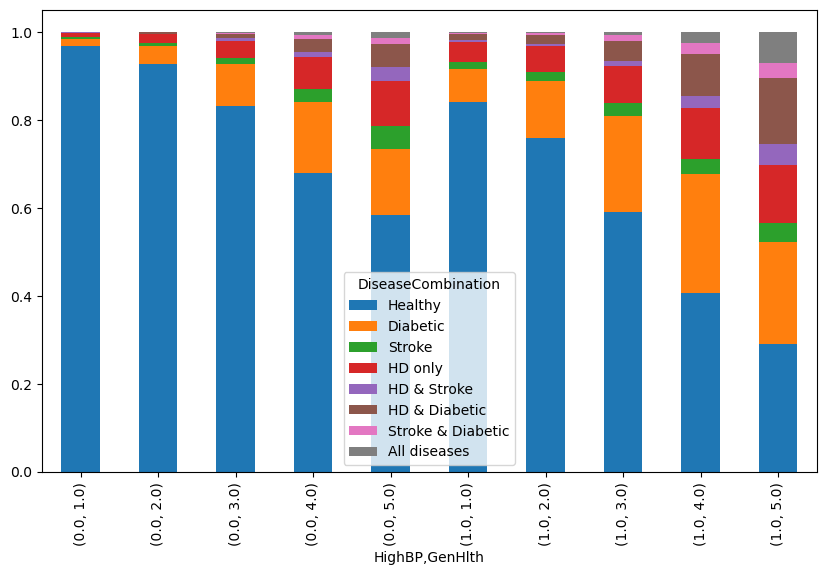

In [13]:
mi,ce_table = calc_mi(['HighBP', 'GenHlth'],['DiseaseCombination'])
column_order = ['Healthy','Diabetic','Stroke','HD only', 'HD & Stroke', 'HD & Diabetic', 'Stroke & Diabetic', 'All diseases']
ce_table = ce_table[column_order]
ce_table.plot(kind = 'bar', stacked=True, figsize=(10,6))

In [14]:
def categorize_age(age):
    if age <= 5:
        return 1
    elif age <= 8:
        return 2
    elif age <= 9:
        return 3
    elif age < 11:
        return 4
    else:
        return 5
    
data['Age_cat'] = data['Age'].apply(categorize_age)
data['Age_cat']=data['Age_cat'].astype('category')

In [15]:
# Convert the filter values to the correct categorical dtype
gen_health_list = data['GenHlth'].cat.categories.tolist()
age_cat_list = data['Age_cat'].cat.categories.tolist()
group_list = []  # Initialize an empty list to store filtered data

# Iterate through each combination of gen_health_list and age_cat_list
for i in gen_health_list:
    for j in age_cat_list:
        # Create the condition using categorical values
        condition = (data['GenHlth'] == i) & (data['Age_cat'] == j)
        filtered_data = data[condition]
        group_list.append(filtered_data)


In [16]:
def calc_mi_v2(x,y, data):
    x_mod = [data[i] for i in x]
    y_mod = [data[i] for i in y]

    contingency_table = pd.crosstab(x_mod, y_mod)
    ce_table = contingency_table / np.expand_dims(contingency_table.sum(axis=1), axis=1)
    rowise_ce = np.apply_along_axis(entropy, 1, ce_table)
    marginal_prob_x = contingency_table.sum(axis=1) / contingency_table.sum().sum()
    ce = np.dot(marginal_prob_x, rowise_ce)

    marginal_prob_y = contingency_table.sum(axis=0) / contingency_table.sum().sum()
    e_y = entropy(marginal_prob_y)

    mi = e_y - ce
    return mi, ce_table

In [17]:
def one_way_mi(data, x_vars):
    mi_x = []
    for var in x_vars:
        mi,_ = calc_mi_v2([var],['DiseaseCombination'], data)
        mi_x.append(mi)
    mi_df = pd.DataFrame({'variable':x_vars,'mutual information':mi_x})
    mi_df = mi_df.sort_values(by='mutual information', ascending=False)
    return mi_df

In [18]:
x_vars.remove('Age')
x_vars.remove('GenHlth')

In [19]:
mi_list = []
for i in range(len(group_list)):
    mi_list.append(one_way_mi(group_list[i], x_vars))

In [20]:
mi_list[21]

,variable,mutual information
0,HighBP,0.047101
1,HighChol,0.037770
16,BMI,0.034017
11,PhysHlth,0.027046
10,MentHlth,0.021293
15,Income,0.016119
12,DiffWalk,0.008971
14,Education,0.008345
2,CholCheck,0.006895
3,Smoker,0.006140


In [21]:
title_list = []
for i in range(1,6):
    for j in range(1,6):
        title = f"({i}, {j})"
        title_list.append(title)
tables_dict = dict(zip(title_list, mi_list))

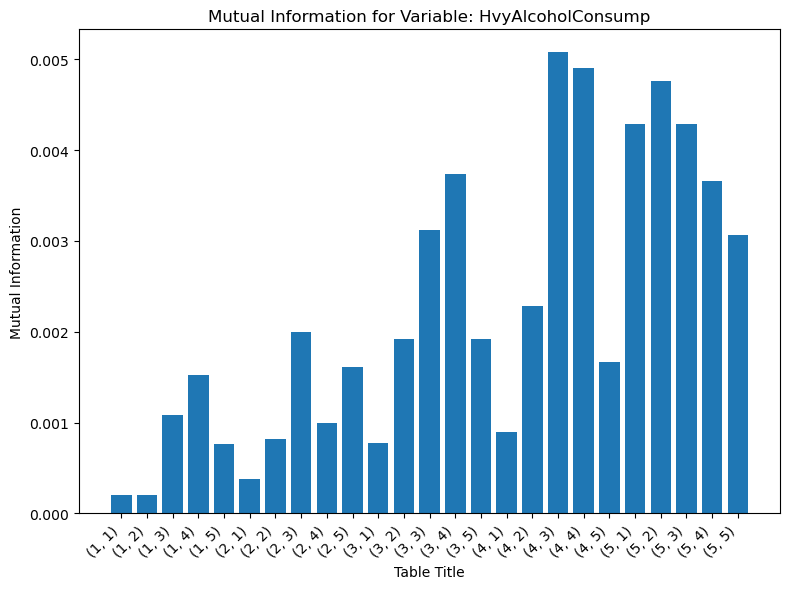

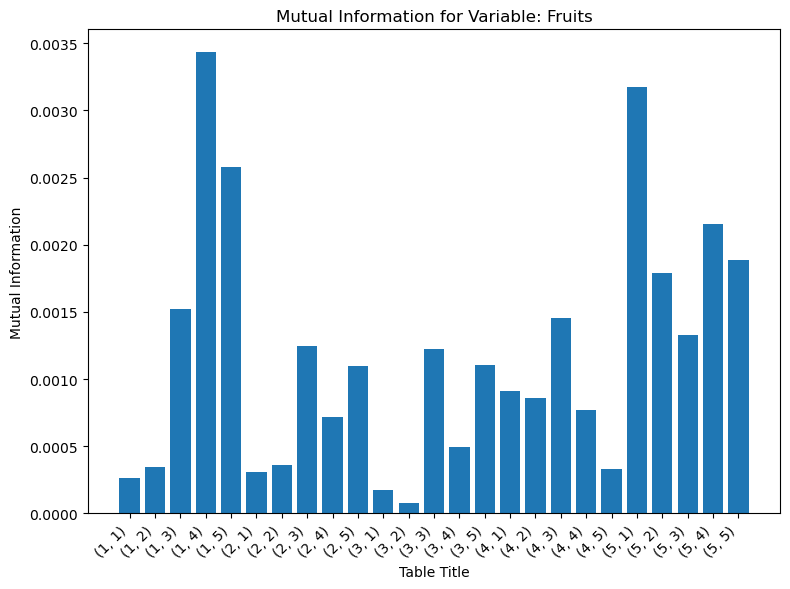

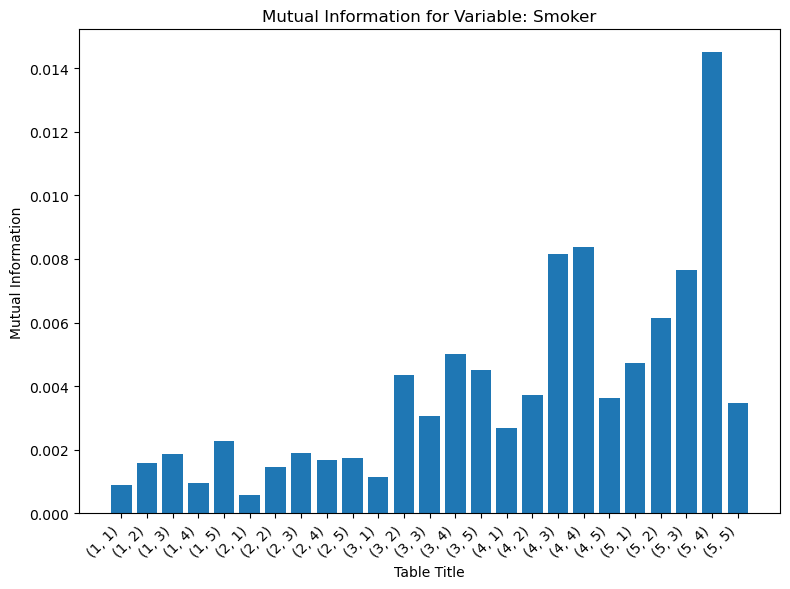

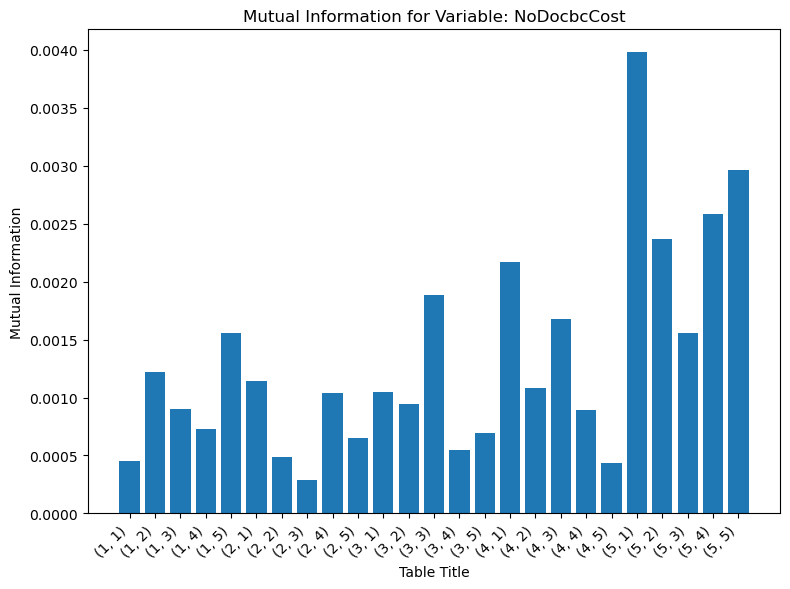

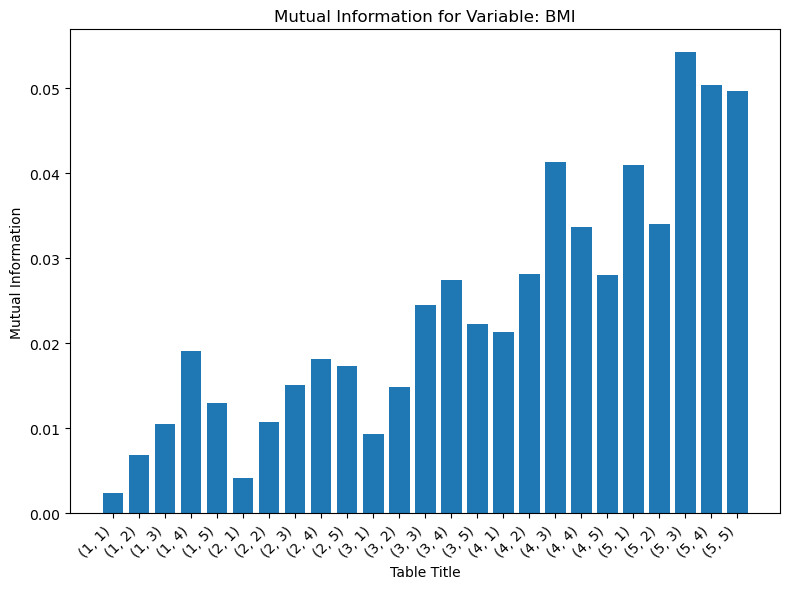

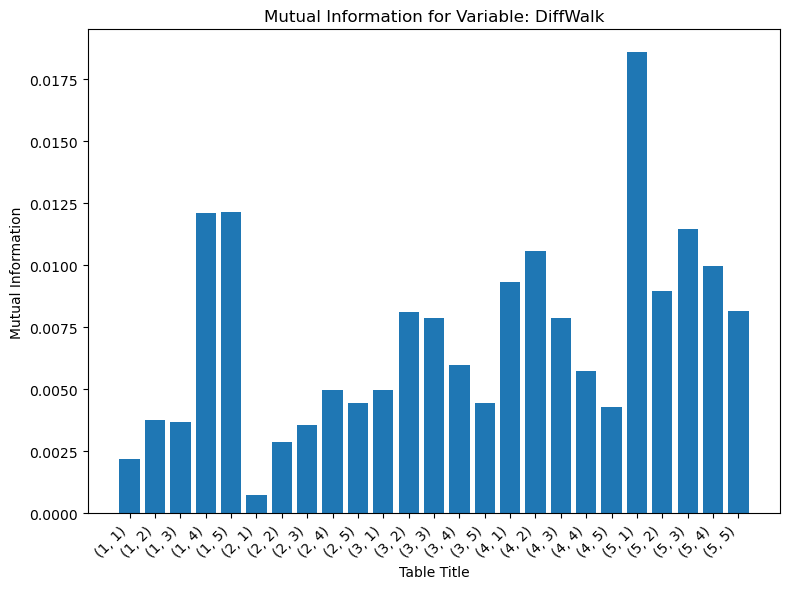

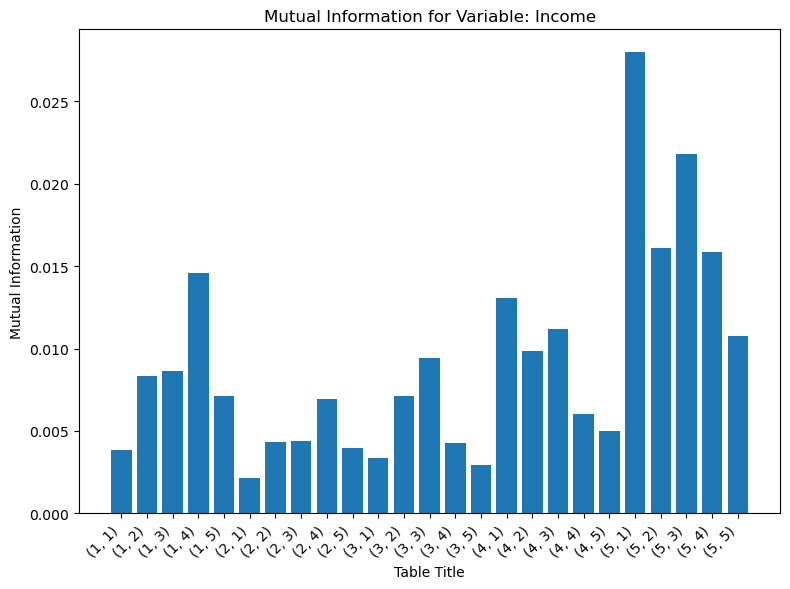

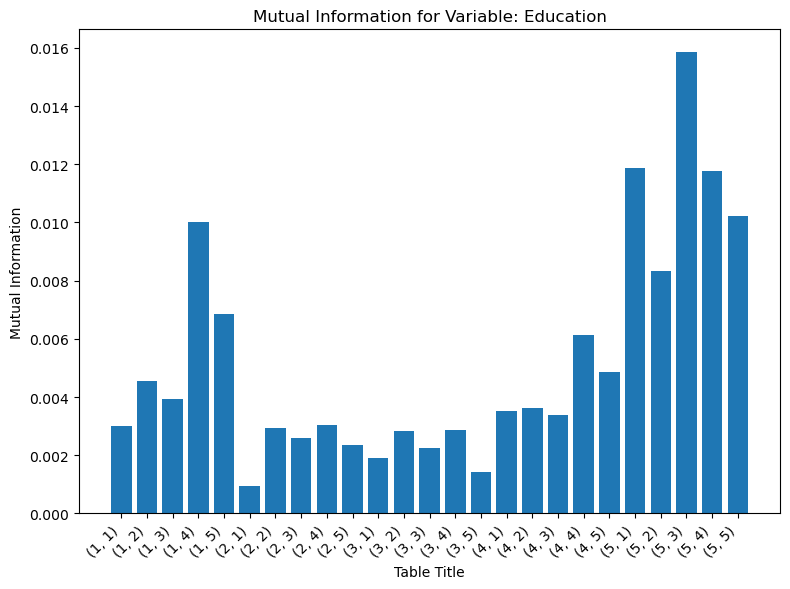

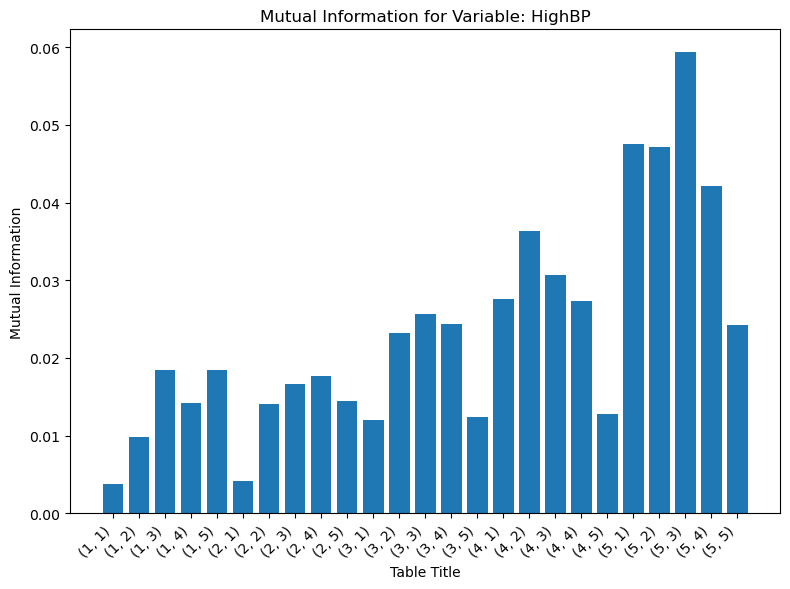

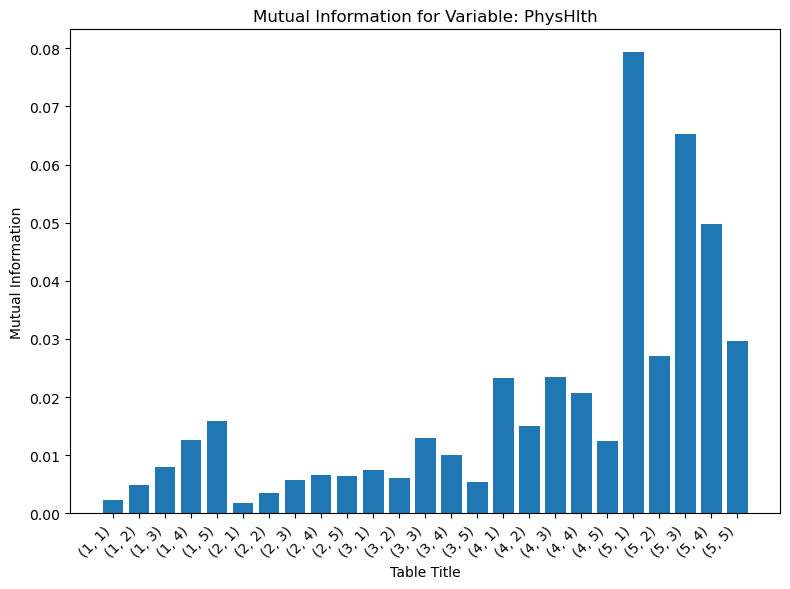

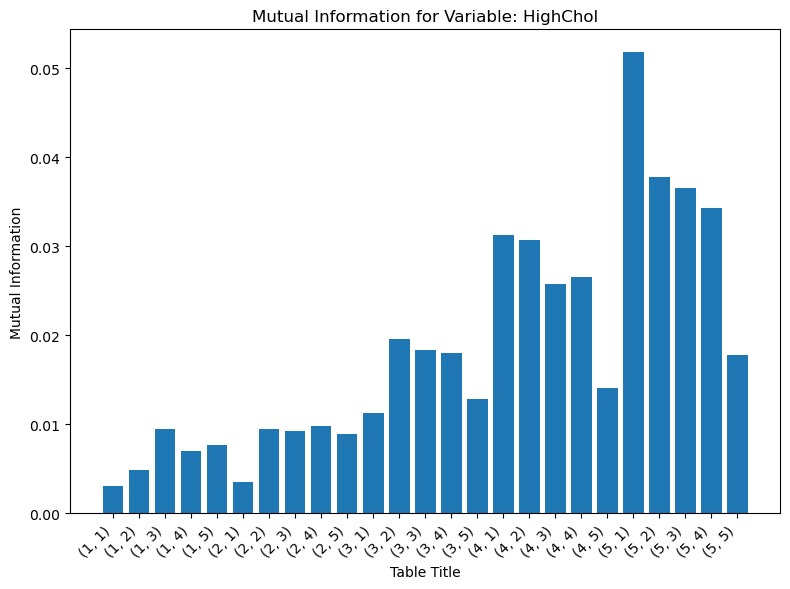

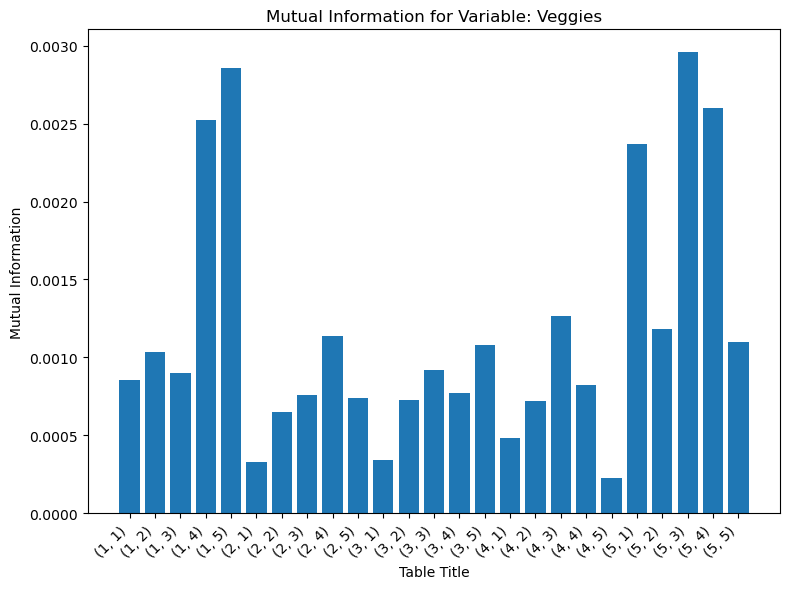

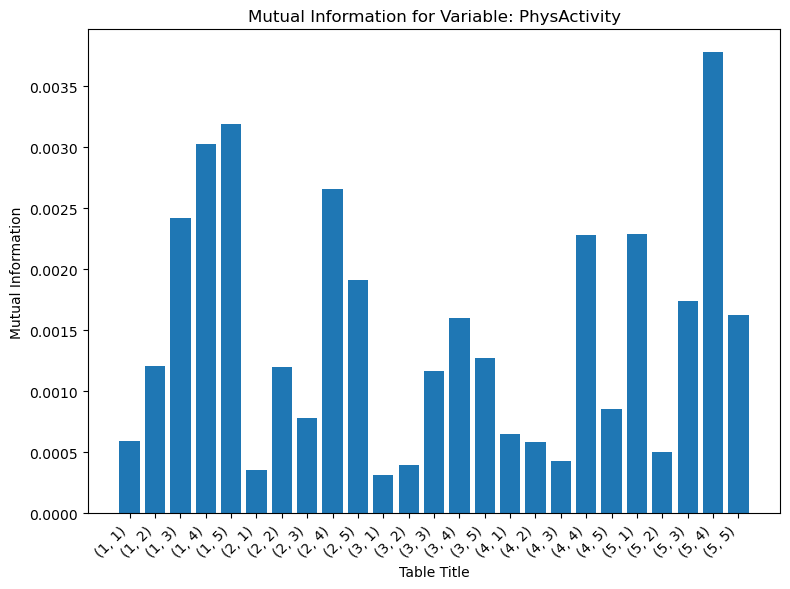

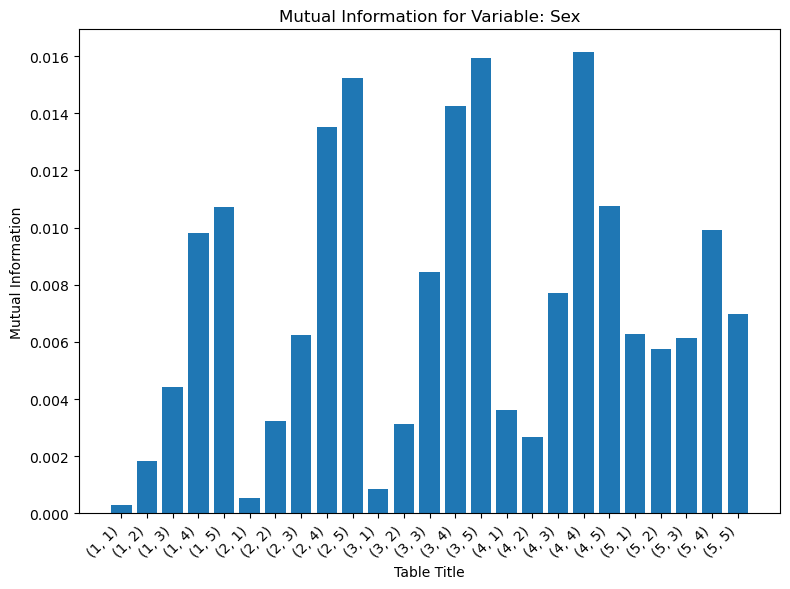

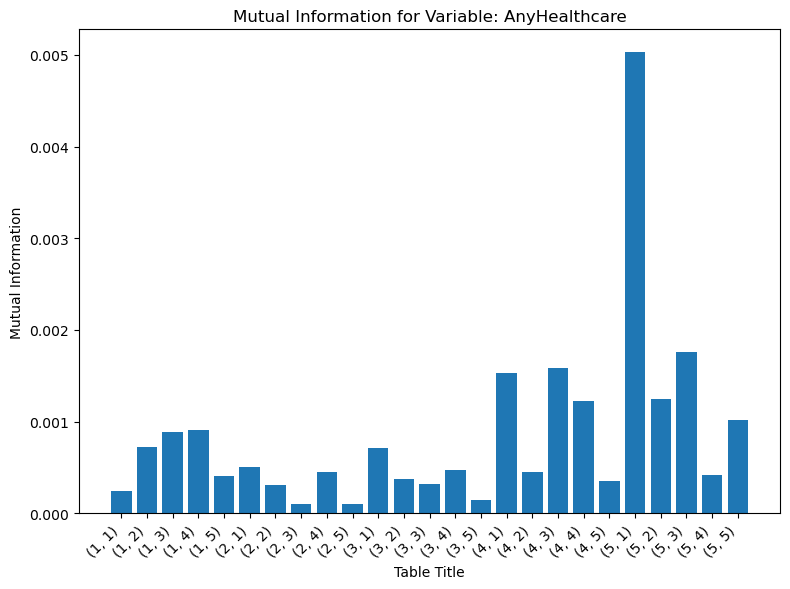

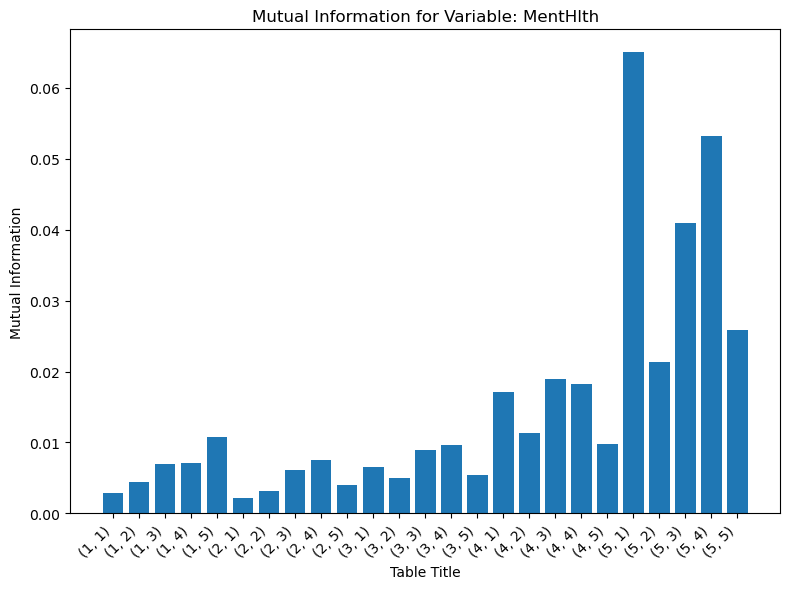

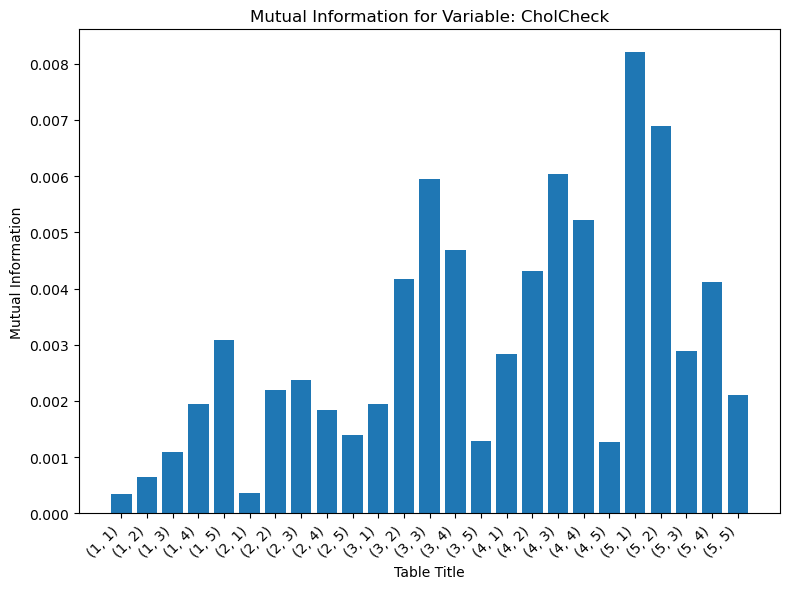

In [22]:
import matplotlib.pyplot as plt

# Sample data (replace this with your actual dictionary)
# Get the unique variables/categories
variables = set()
for table in tables_dict.values():
    variables.update(table['variable'])

# Create a separate plot for each variable
for variable in variables:
    plt.figure(figsize=(8, 6))
    plt.title(f'Mutual Information for Variable: {variable}')
    plt.xlabel('Table Title')
    plt.ylabel('Mutual Information')
    
    x_values = []
    y_values = []
    for title, table in tables_dict.items():
        if variable in table['variable'].values:
            x_values.append(title)
            y_values.append(table.loc[table['variable'] == variable, 'mutual information'].values[0])
    
    plt.bar(x_values, y_values)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()


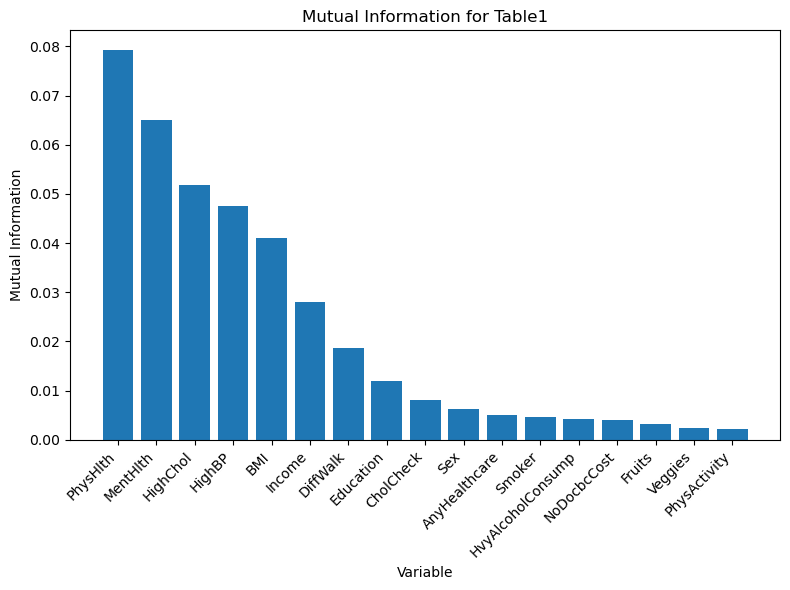

In [23]:
table1_data = tables_dict['(5, 1)']

# Create bar plot for Table1
plt.figure(figsize=(8, 6))
plt.bar(table1_data['variable'], table1_data['mutual information'])
plt.xlabel('Variable')
plt.ylabel('Mutual Information')
plt.title('Mutual Information for Table1')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

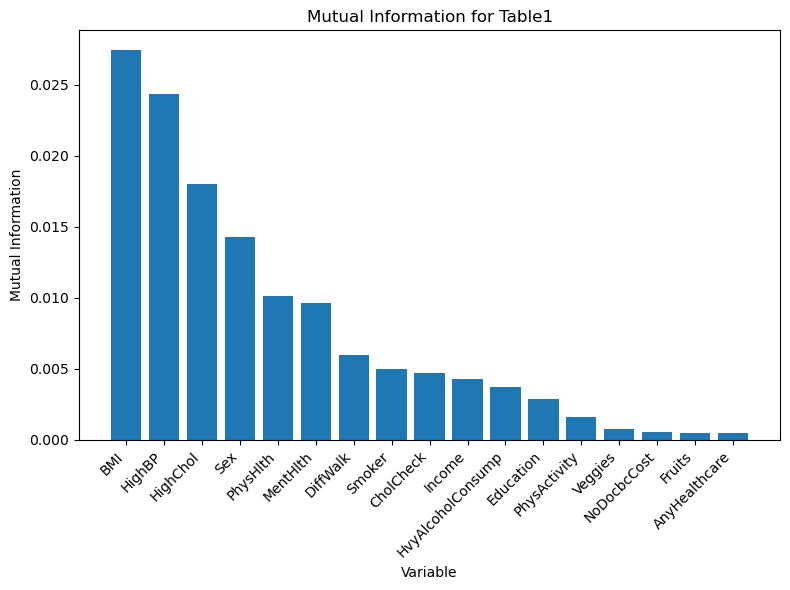

In [24]:
table1_data = tables_dict['(3, 4)']

# Create bar plot for Table1
plt.figure(figsize=(8, 6))
plt.bar(table1_data['variable'], table1_data['mutual information'])
plt.xlabel('Variable')
plt.ylabel('Mutual Information')
plt.title('Mutual Information for Table1')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()